# Basics on Mathematical Morphology

## Introduction

Mathematical morphology (MM) is a branch of image processing. MM is a theory and technique for the analysis and processing of geometrical structures, based on set theory, lattice theory, topology, and random functions.

MM consists of a set of operators that transform images according to characterizations based on size, shape, convexity among others.
MM was originally developed for binary images, and was later extended to grayscale functions and images. The generalization to complete lattices is widely accepted today as MM's theoretical foundation.

In the same way that linear image processing puts the emphasis on the transformations that commute with
addition, mathematical morphology stresses the transformations that commute with the sup or, by duality, with
the inf

Recommended lecture:

[MATHEMATICAL MORPHOLOGY, I.Bloch,H. Heijmans and C. Ronse](https://perso.telecom-paristech.fr/bloch/papers/SpaceBook.pdf)

Some recommended books:

{cite}`serra83`
{cite}`soille03`
{cite}`najman13`




In this document, we explain how to implement flat morphological operators in [tensorflow](https://tensorflow.org) by means of morpholayers library.

In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
import skimage
print('TensorFlow version:',tensorflow.__version__)
print('Numpy version:',np.__version__)
print('Skimage version:',skimage.__version__)

TensorFlow version: 2.2.0
Numpy version: 1.18.1
Skimage version: 0.15.0


In [2]:
from morpholayers import *
from morpholayers.layers import Dilation2D,Erosion2D,Closing2D,Opening2D,reconstruction_dilation,reconstruction_erosion

```{note}
morpholayers only works on tensorflow version >= 2.0.0.
```

The implementation is based on non-flat operators on Tensorflow:
1. [https://www.tensorflow.org/api_docs/python/tf/nn/dilation2d](https://www.tensorflow.org/api_docs/python/tf/nn/dilation2d)
2. [https://www.tensorflow.org/api_docs/python/tf/nn/erosion2d](https://www.tensorflow.org/api_docs/python/tf/nn/erosion2d)

In [3]:
from tensorflow.keras.layers import Input,Lambda
from tensorflow.keras.models import Model

In [4]:
from imageio import imread

We wiil use the following example, to illustrate the effect of morphological transformation.

(256, 256, 1)


<Figure size 432x288 with 0 Axes>

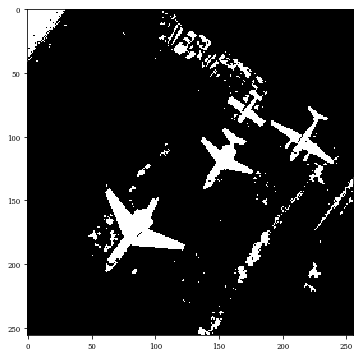

In [5]:
I=imread('./Images/airplane00.png')*1.
plt.gray()
#plt.figure(figsize=(6,6))
#plt.imshow(I[:,:,0])
#plt.show()
I=(I[:,:,0:1]>200)*1.
print(I.shape)
size_im=I.shape
plt.figure(figsize=(6,6))
plt.imshow(I[:,:,0])
plt.show()


$\newcommand{\image}{{I}}$
$\newcommand{\dilation}{{\delta}}$
$\newcommand{\erosion}{{\varepsilon}}$
$\newcommand{\opening}{{\gamma}}$
$\newcommand{\closing}{{\varphi}}$
$\newcommand{\SE}{\mathbf{W}}$
$\newcommand{\id}{\texttt{id}}$
$\newcommand{\lattice}{{\mathcal{L}}}$


## Dilation

The most basic morphological operations are dilation and erosion.

For a given image $\image$ of dimension $M,N$ pixels in $C$ channels, the **{index}`dilation`** layer uses $\texttt{tf.nn.dilation2d}$ which implements the channelwise max-plus convolution:

\begin{equation}
\dilation_{\SE}(\image):=\bigvee_{dy,dx} \left ( \image(y+dy,x+dx, c) + \SE(dy,dx,c) \right )
\end{equation}


where by convention, $\SE(dx,dy)=-\infty$, for $(dx,dy)$ not in the support of $\SE$.
The support of $\SE$ is defined by the parameter kernel_size.


Comments: 
1. Allows to compute backpropagation on the parameter $\SE$

2. Each input channel is processed independently of the others with its own structuring function.

3. Allows to use strides and rates for filters with "Dilated convolutions".

4. Only "NHWC" is currently supported. (Channel last format)

```{note}
For "kernel_initializer=zeros" is used by default, meaning the erosion uses a square flat structuring element of size kernel_size.
```

In [6]:
InLayer=Input(size_im)
x=Dilation2D(1,kernel_size=(7,7),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
dilation2d (Dilation2D)      (None, 256, 256, 1)       49        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


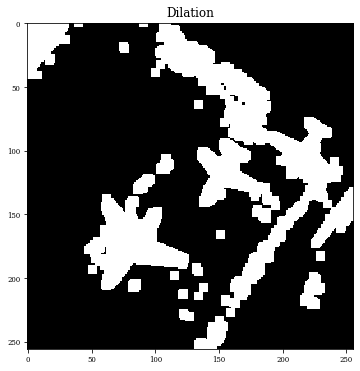

In [7]:
Z=model.predict(np.expand_dims(I,axis=0))
plt.figure(figsize=(6,6))
plt.title('Dilation')
plt.imshow(Z[0,:,:,0]/255)
plt.show()

The kernel_size controls the size of structuring element. As kernel_initializer='zeros' is the default parameter, the follow example performs dilations by a square of side 3,5,7 and 9.

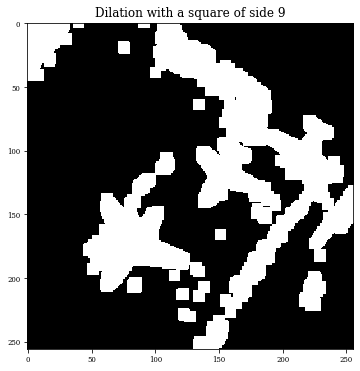

In [40]:
for se in range(3,10,2):
    InLayer=Input(size_im)
    x=Dilation2D(1,kernel_size=(se,se))(InLayer)
    model=Model(InLayer,x)
    Z=model.predict(np.expand_dims(I,axis=0))
    plt.figure(figsize=(6,6))
    plt.title('Dilation with a square of side '+str(se))
    plt.imshow(Z[0,:,:,0]/255)
    plt.show()

One of the advantage of using the tensorflow implementation can treat with set of images, called batches.
The following example performs dilation for grey scale images for a batch of ten images.

In [45]:
import os
filelist= [file for file in os.listdir('./Images/') if file.endswith('.png')]
print('List of images',filelist)
Batch=[]
for imagei in filelist:
    Batch.append(np.expand_dims(((imread('./Images/'+imagei))[:,:,0:1])*1.,axis=0))
Batch=np.concatenate(Batch,axis=0)
print('Batch size',Batch.shape)

List of images ['airplane42.png', 'airplane96.png', 'airplane69.png', 'airplane51.png', 'airplane46.png', 'airplane47.png', 'airplane22.png', 'airplane00.png', 'airplane17.png', 'airplane07.png']
Batch size (10, 256, 256, 1)


Here, we have the original images.

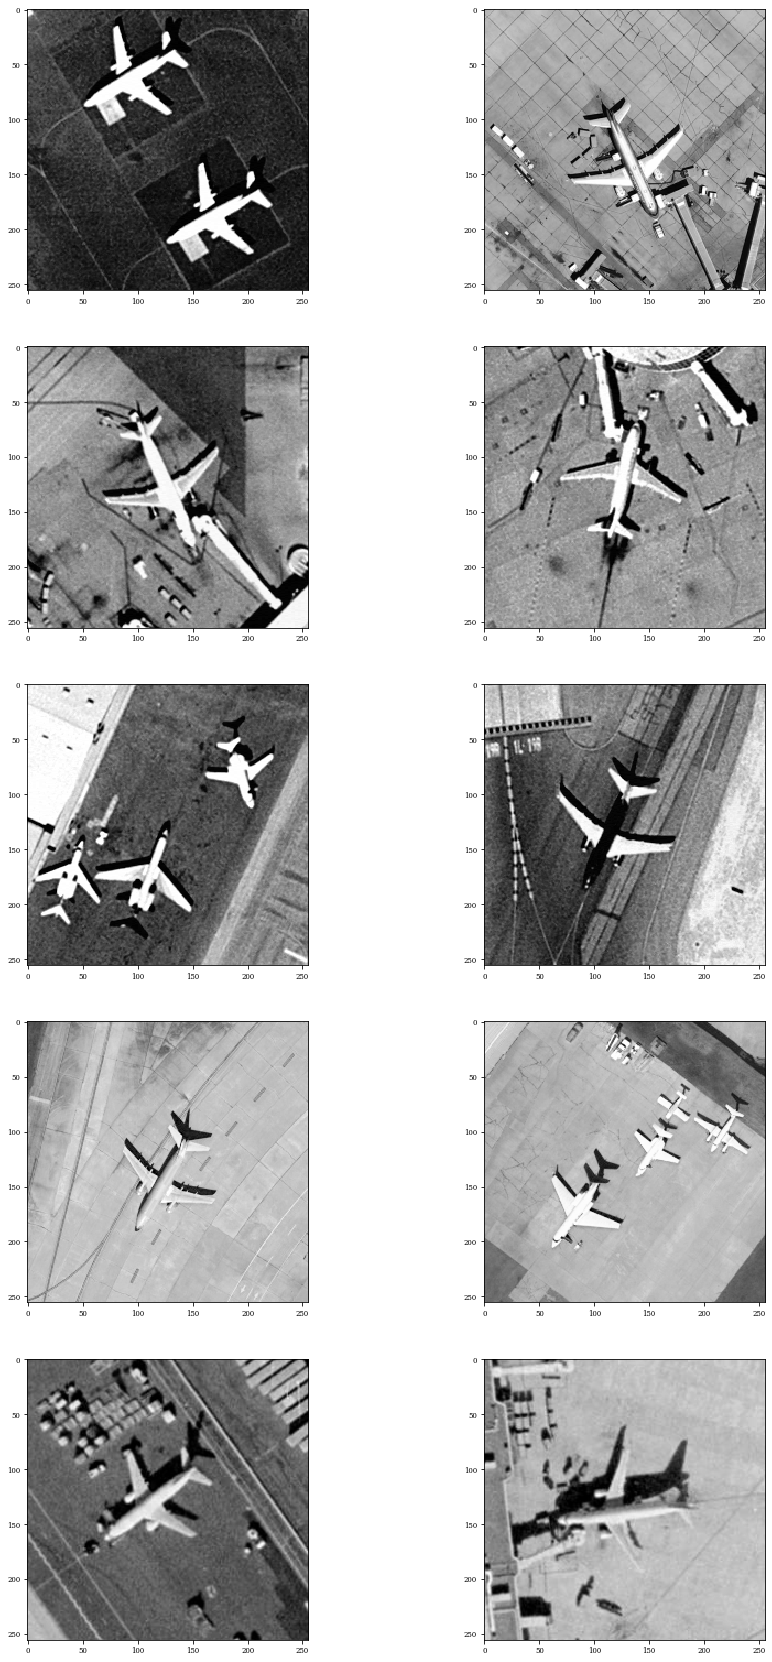

In [105]:
plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Batch[i,:,:,0])
plt.show()

In [47]:
Z=model.predict(Batch)

Dilations with a square of side 9

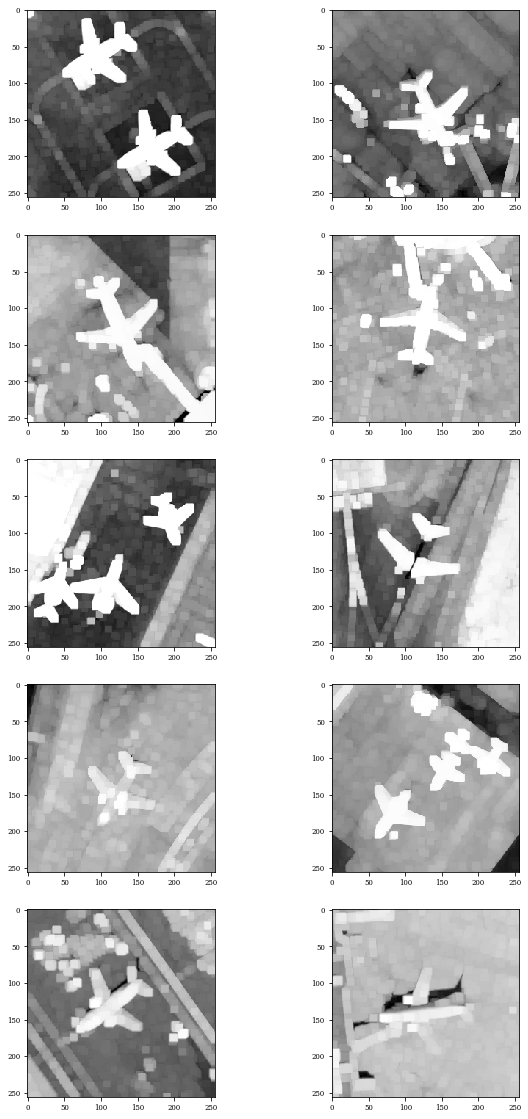

In [48]:
plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

## Erosion

For a given image $\image$ of dimension $M,N$ pixels in $C$ channels, this **{index}`erosion`** layer uses $\texttt{tf.nn.erosion2d}$ which implements the channelwise min-plus convolution:

\begin{equation}
\erosion_{\SE}(\image):=\bigwedge_{dy,dx} \left ( \image(y-dy,x-dx, c) - \SE(dy,dx,c) \right )
\end{equation}


where by convention, $\SE(dx,dy)=-\infty$, for $(dx,dy)$ not in the support of $\SE$.
The support of $\SE$ is defined by the parameter kernel_size.


Comments: 
1. Allows to compute backpropagation on the parameter $\SE$

2. Each input channel is processed independently of the others with its own structuring function.

3. Allows to use strides and rates for filters with "Dilated convolutions".

4. Only "NHWC" is currently supported. (Channel last format)

```{note}
For "kernel_initializer=zeros" is used by default, meaning the erosion uses a square flat structuring element of size kernel_size.
```

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
erosion2d_1 (Erosion2D)      (None, 256, 256, 1)       25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


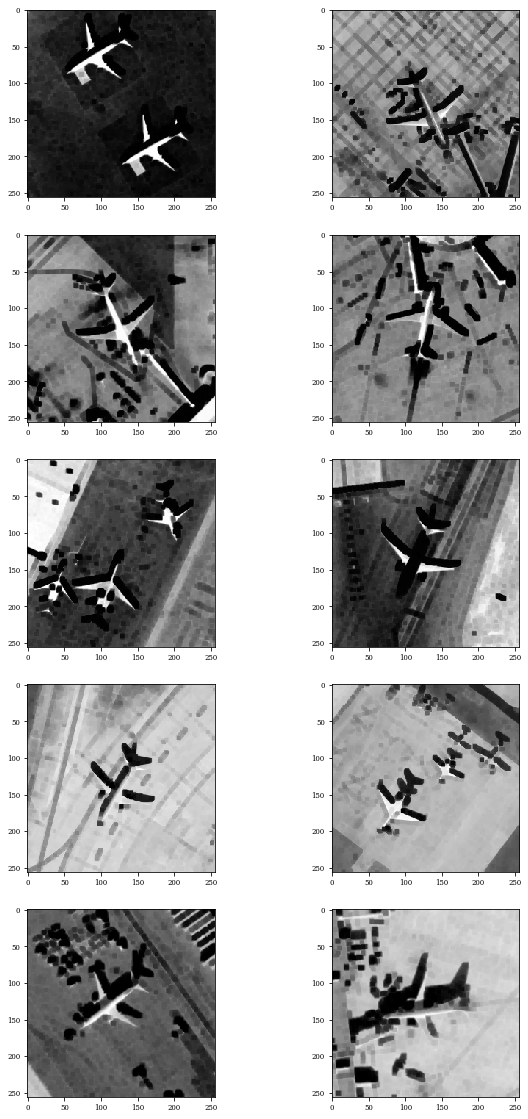

In [50]:
InLayer=Input(size_im)
x=Erosion2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

## Idempotent transfromations
### Opening
The operator **{index}`opening`** is an idempotent transformation defined by composition of erosion and dilation

\begin{equation}
\opening_{\SE}(\image):=\dilation_{\SE}(\erosion_{\SE}(\image))
\end{equation}



In [53]:
InLayer=Input(size_im)
x=Opening2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
opening2d_2 (Opening2D)      (None, 256, 256, 1)       25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


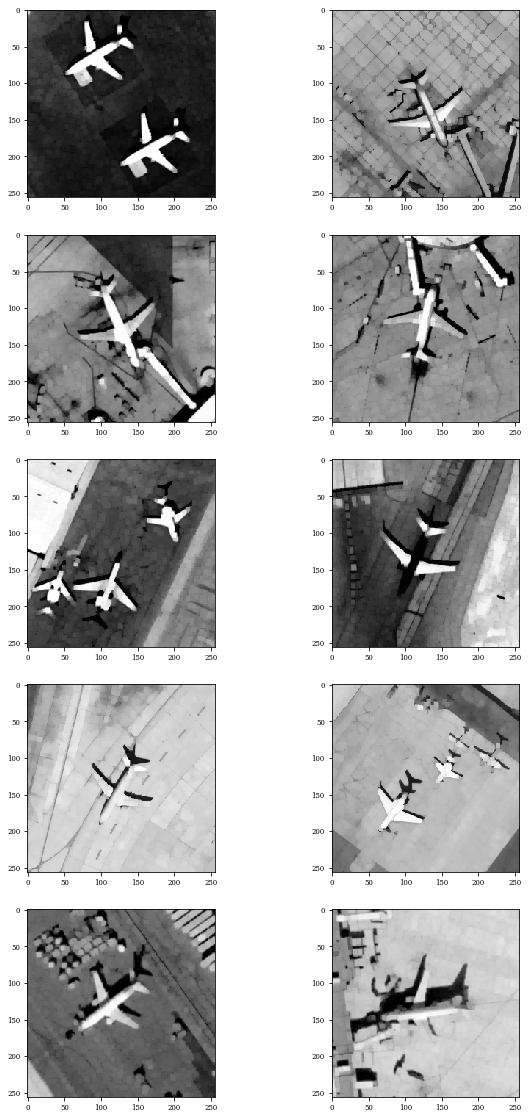

In [54]:
Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

### Closing

Duality, the morphological **{index}`closing`** is an idempotent transformation defined by composition of dilation and erosion

\begin{equation}
\closing_{\SE}(\image):=\erosion_{\SE}(\dilation_{\SE}(\image))
\end{equation}
   

For flat structuring elements, their effect are also intuitive: Closing removes “holes” and thin cavities, and opening removes small object protuberances. 
One of the most interesting properties for $(\closing(\cdot),\opening(\cdot))$ is that they obey the **{index}`absortion law`**, i.e.
$\closing_{\SE_1}(\closing_{\SE_2} (\image)) =  \closing_{\SE_{1}} (I)$ and  $\opening_{\SE_1}(\opening{\SE_2} (\image)) =  \opening_{\SE_{1}} (I)$
if $\SE_2\le \SE_1$.

In [55]:
InLayer=Input(size_im)
x=Closing2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
closing2d (Closing2D)        (None, 256, 256, 1)       49        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


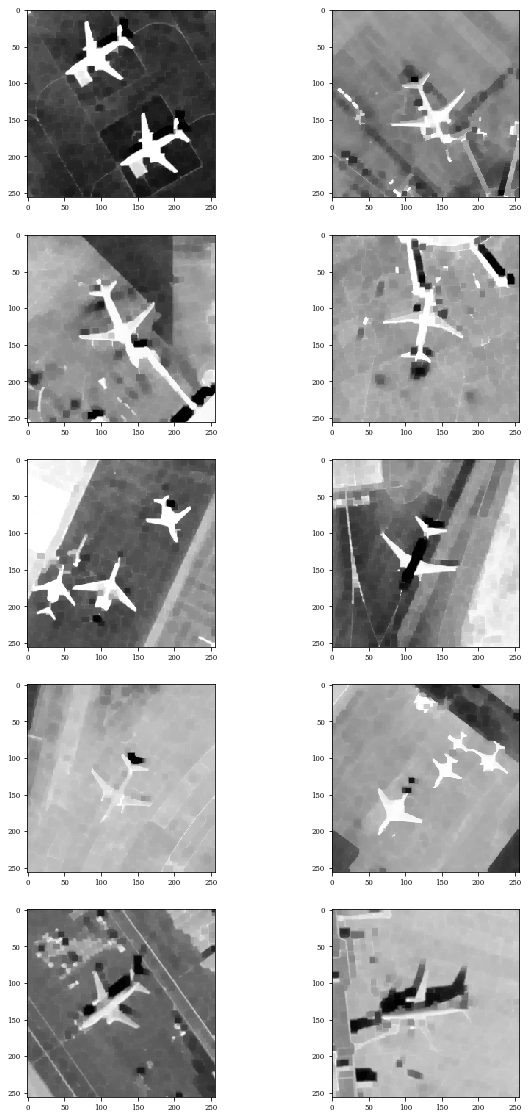

In [56]:
Z=model.predict(Batch)
plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

## Residual Operators

Residual operators are transformations that involve combinations of morphological operators with differences.

### Morphological Gradients 

The basic example is the morphological gradient, also called **{index}`Beucher gradient`**, which is defined as the arithmetic difference between the dilation 
and the erosion. This morphological gradient is denoted by $\rho$:

            
\begin{equation}
\Delta_{\SE}(\image):=\dilation_{\SE}(\image)-\erosion_{\SE}(\image)
\end{equation}


The **half-gradient by erosion** or **{index}`internal gradient`** $\rho^{-}$ is defined as the difference between the input image and the eroded image:

            
\begin{equation}
\Delta_{\SE}^{-}(\image):=\image-\erosion_{\SE}(\image)
\end{equation}

The internal gradient enhances internal boundaries of objects brighter than thier background and external borders of objects darker than their background.




In [57]:
from morpholayers.layers import Gradient2D,InternalGradient2D

In [58]:
InLayer=Input(size_im)
x=Gradient2D(1,kernel_size=(3,3),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
gradient2d (Gradient2D)      (None, 256, 256, 1)       9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
internal_gradient2d (Interna (None, 256, 256, 1)       9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


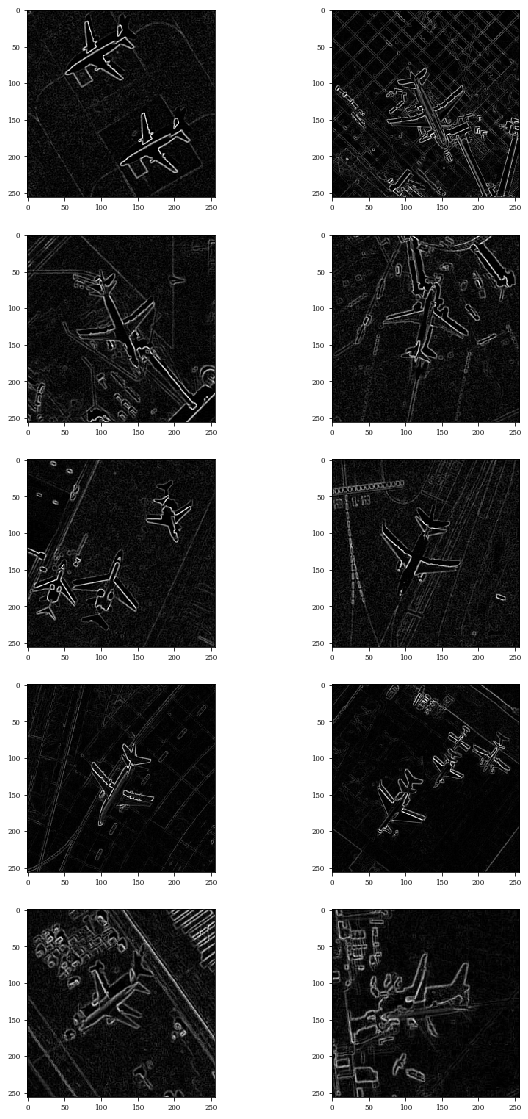

In [59]:
InLayer=Input(size_im)
x=InternalGradient2D(1,kernel_size=(3,3),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

### Top-Hats
Top-hats are defined as the residue of image and its opening or its closings. **{index}`Top-hat transform`** is an operation that extracts small elements and details from given images. There are two types of top-hat transform — the white top-hat transform and the black top-hat transform. 
The white top-hat transform can be defined as the difference between the input image and its opening by some structuring element,

\begin{equation}
\rho^{+}(\image)=\image-\opening_{\SE}(\image)
\end{equation}


while the black top-hat transform can be defined as the difference between the closing and the input image.

\begin{equation}
\rho^{-}(\image)=\closing_{\SE}(\image)-\image
\end{equation}

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
top_hat_closing2d (TopHatClo (None, 256, 256, 1)       25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


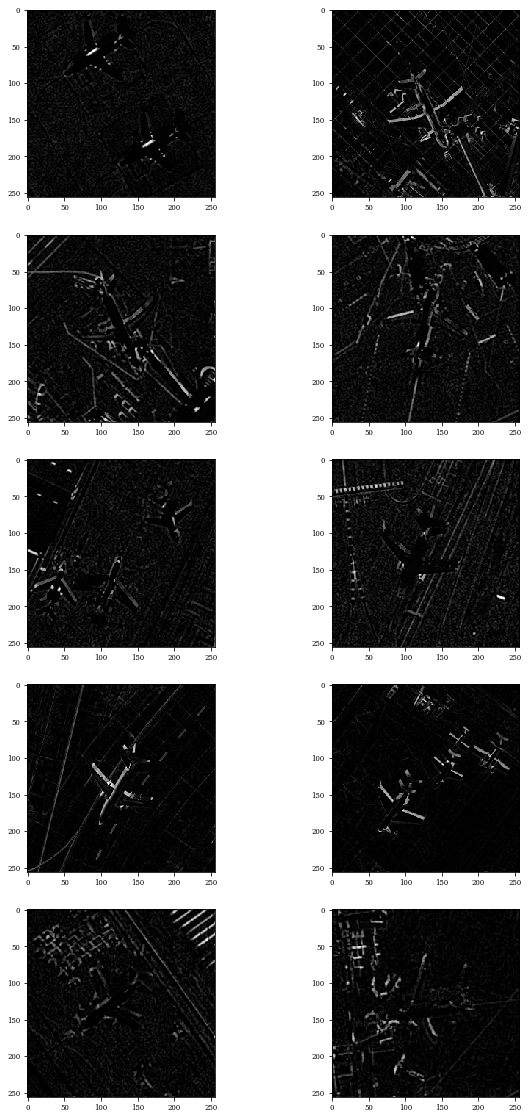

In [60]:
from morpholayers.layers import TopHatClosing2D,TopHatOpening2D
InLayer=Input(size_im)
x=TopHatClosing2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
top_hat_opening2d (TopHatOpe (None, 256, 256, 1)       25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


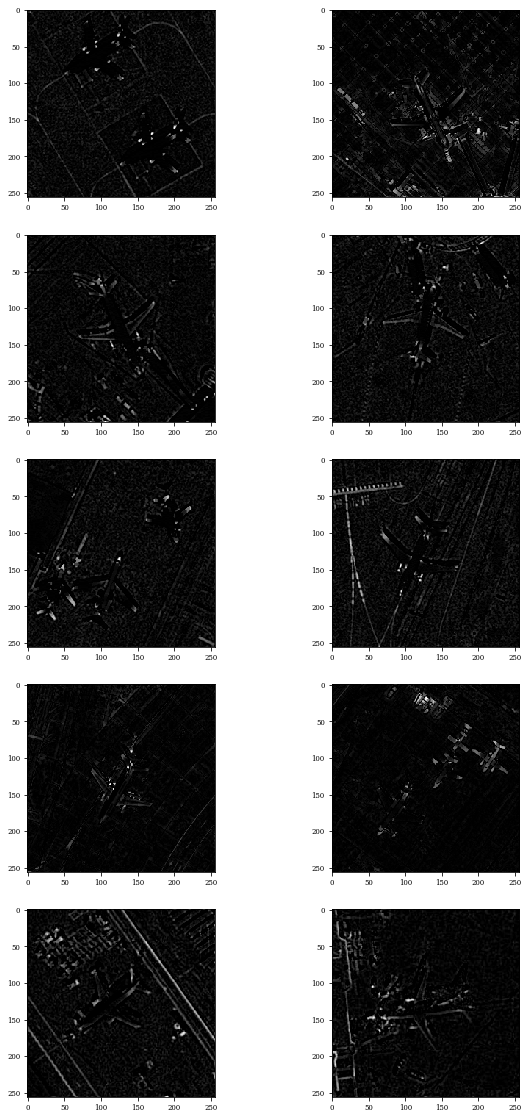

In [61]:
InLayer=Input(size_im)
x=TopHatOpening2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
top_hat_closing2d_1 (TopHatC (None, 256, 256, 1)       25        
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


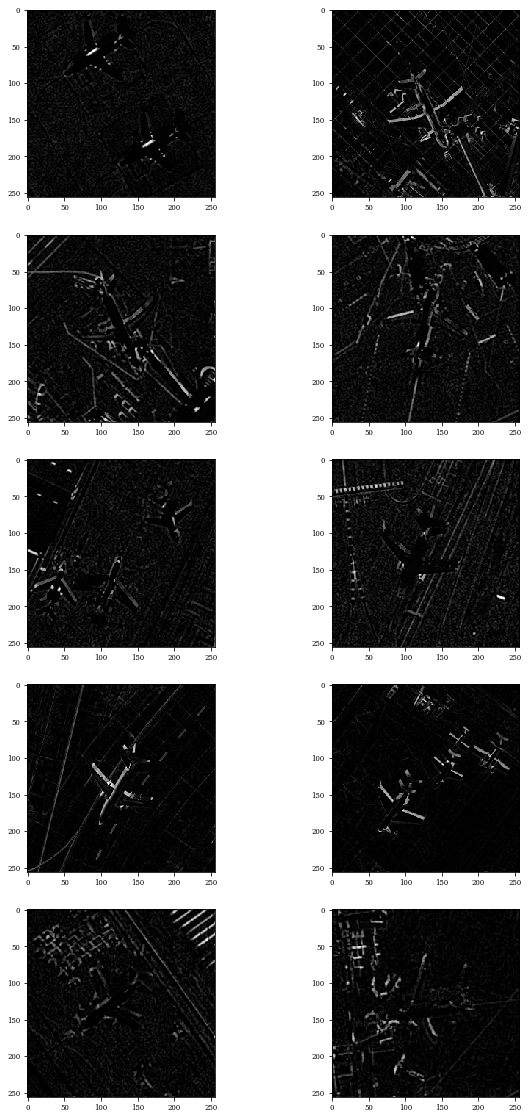

In [97]:
InLayer=Input(size_im)
x=TopHatClosing2D(1,kernel_size=(5,5),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

### Morphological Probing
The **{index}`morphological probing`** measures the distance between a dilation with $\SE_1$ and an erosion with $\SE_2$. This has been proposed as an extension of Hit-or-miss operator for grey-scale images. 


\begin{equation}
\vartheta_{\SE_1,\SE_2}(\image):=\dilation_{\SE_1}(\image)-\erosion_{\SE_2}(\image)
\end{equation}

Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
probing2d (Probing2D)        (None, 256, 256, 1)       18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


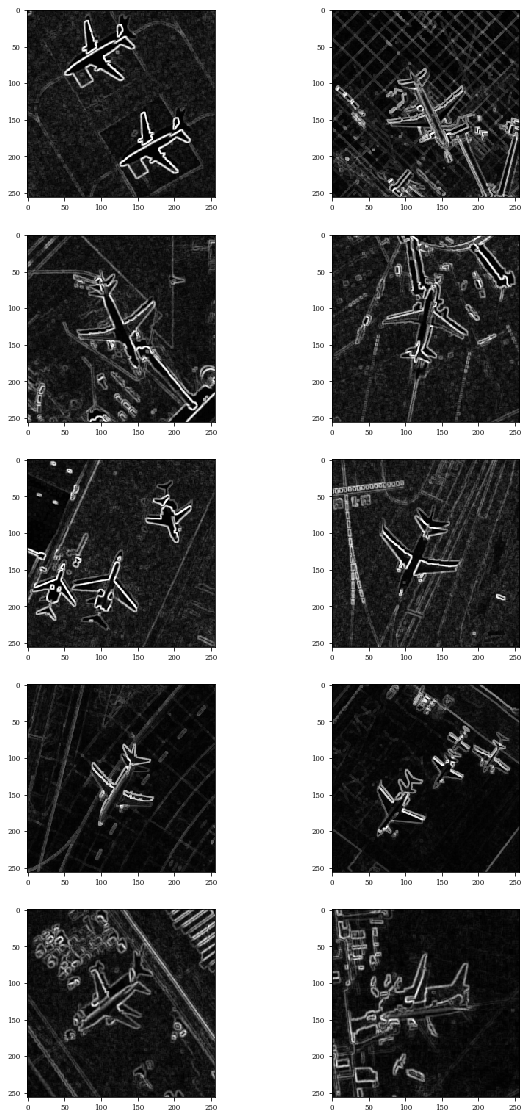

In [62]:
from morpholayers.layers import Probing2D
InLayer=Input(size_im)
x=Probing2D(1,kernel_size=(3,3),kernel_initializer='zeros')(InLayer)
model=Model(InLayer,x)
model.summary()

Z=model.predict(Batch)

plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

## Morphological Reconstruction

### Geodesic dilation

It is often desirable to remove small objects from the image, while keeping larger objects totally intact. 
A morphological approach to answer this is the **{index}`morphological reconstruction`**. For example, in the case of reconstruction by dilation, 
an image $M$ is dilated in the usual way, but constrained so as to never grow outside the “control” image $M$, called marker image. 
This operator is iterated until convergence is reached. 

The **{index}`geodesic dilation`** of size 1 of the marker image $\image$ with respect to the mask input $M$ is denoted by 
$\dilation_{M}^{(1)}(\image)$ and is defined as the pointwise minimum between the mask image and the elementary dilation 
$\dilation_{\mathbf{B}}^{(1)}$ of the marker image, i.e., 

\begin{equation}
\dilation_{M}^{(1)}(\image):=\dilation_{\mathbf{B}}^{(1)}(\image) \wedge M
\end{equation}

This operator is iterated until convergence is reached. Similarly, the reconstruction by erosion uses standard erosion and the dual constrain. We use the notation $\erosion^{\infty}(M,\image)$ and $\dilation^{\infty}(M,\image)$ for the couple erosion and dilation by reconstruction.

```{note}
This layer do not have trainable parameters
```

```{warning}
In the implementation the operator is iterated a fixed number of times "steps" and not until convergence. The value by default is given in NUM_ITER_REC
```

#### Example Opening by Reconstruction

This operator **{index}`opening by reconstruction`** is defined as $\dilation^{\infty}(\opening_{\SE}(\image),\image)$

In [90]:
InLayer=Input(size_im)
Marker=Opening2D(1,kernel_size=(7,7),kernel_initializer='zeros')(InLayer)
x=Lambda(reconstruction_dilation,arguments={'steps':15})([Marker,InLayer]) #Mask,Image
model=Model(InLayer,outputs=[x,Marker])
model.summary()




Model: "model_28"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
opening2d_7 (Opening2D)         (None, 256, 256, 1)  49          input_29[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 1)  0           opening2d_7[0][0]                
                                                                 input_29[0][0]                   
Total params: 49
Trainable params: 49
Non-trainable params: 0
__________________________________________________________________________________________________


In [91]:
Z=model.predict(Batch)
print(len(Z[0]))
print(Z[0].shape)

10
(10, 256, 256, 1)


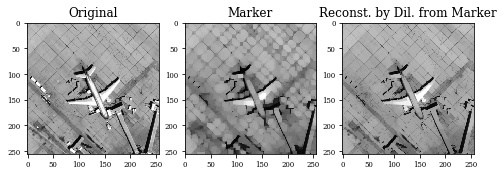

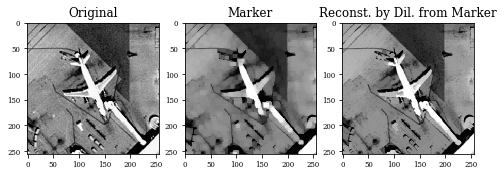

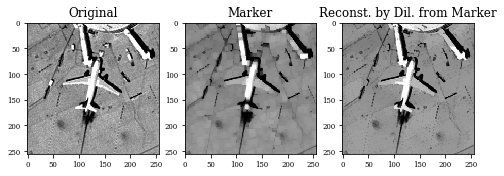

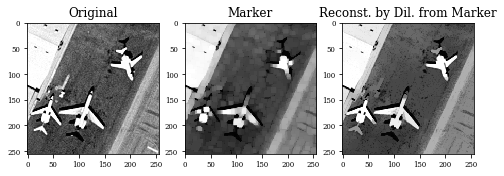

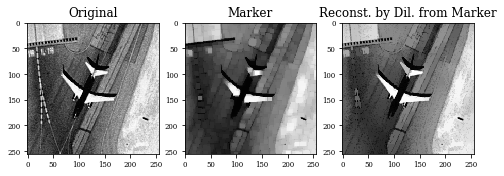

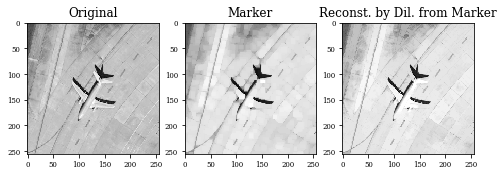

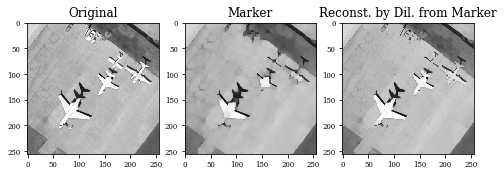

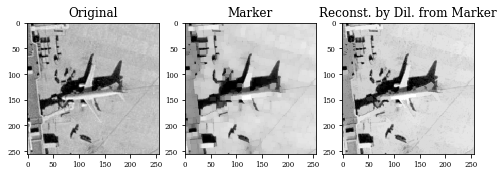

In [93]:
for i in range(len(Z[0])):
    plt.figure(figsize=(15,30))
    plt.subplot(1,3,1)
    plt.imshow(Batch[i,:,:,0])
    plt.title('Original')
    plt.subplot(1,3,2)
    plt.title('Marker')
    plt.imshow(Z[1][i,:,:,0])
    plt.subplot(1,3,3)
    plt.title('Reconst. by Dil. from Marker')
    plt.imshow(Z[0][i,:,:,0])
    plt.show()

#### Example of Closing by reconstruction

This operator **{index}`closing by reconstruction`** is defined as $\erosion^{\infty}(\closing_{\SE}(\image),\image)$

In [94]:
InLayer=Input(size_im)
Marker=Closing2D(1,kernel_size=(7,7),kernel_initializer='zeros')(InLayer)
x=Lambda(reconstruction_erosion,arguments={'steps':15})([Marker,InLayer])
model=Model(InLayer,outputs=[x,Marker])
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
closing2d_1 (Closing2D)         (None, 256, 256, 1)  49          input_30[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 256, 256, 1)  0           closing2d_1[0][0]                
                                                                 input_30[0][0]                   
Total params: 49
Trainable params: 49
Non-trainable params: 0
__________________________________________________________________________________________________


In [95]:
Z=model.predict(Batch)

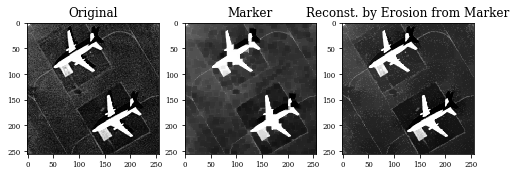

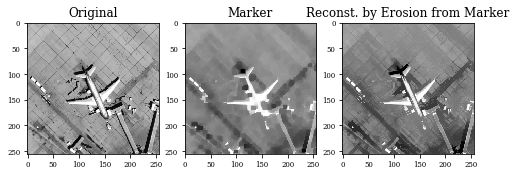

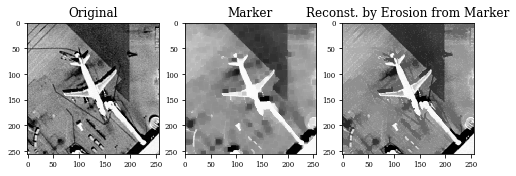

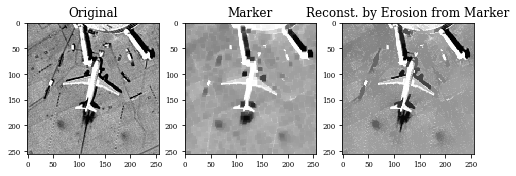

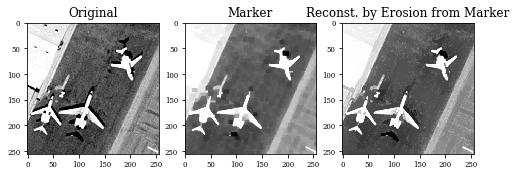

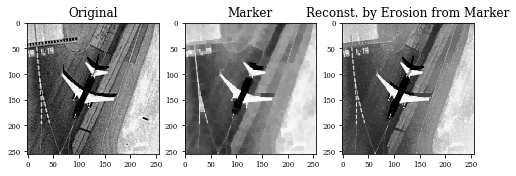

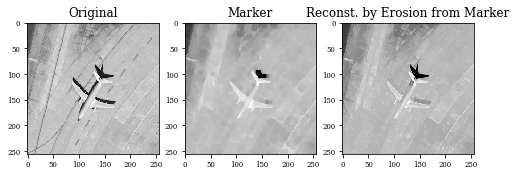

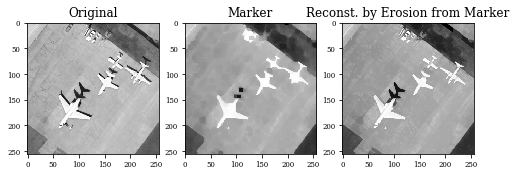

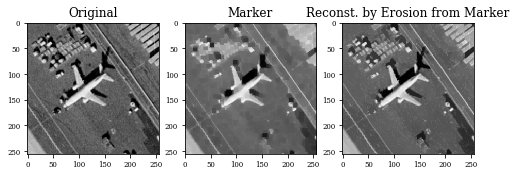

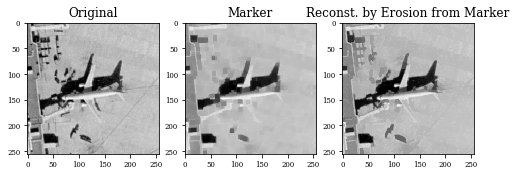

In [96]:
for i in range(len(Z[0])):
    plt.figure(figsize=(15,30))
    plt.subplot(1,3,1)
    plt.imshow(Batch[i,:,:,0])
    plt.title('Original')
    plt.subplot(1,3,2)
    plt.title('Marker')
    plt.imshow(Z[1][i,:,:,0])
    plt.subplot(1,3,3)
    plt.title('Reconst. by Erosion from Marker')
    plt.imshow(Z[0][i,:,:,0])
    plt.show()

## Contrast mappings

The **{index}``contrast mapping``** is a particular operator from a more general class of transformations called
toggle mappings Serra (1989b). A contrast mapping is defined, on the one hand, by two primitives

$\Phi_1$ and $\Phi_2$ applied to the initial function, and on the other hand, by a decision rule which makes, at
each point $x$ the output of this mapping toggles between the value of $\Phi_1$ at x and the value of $\Phi_2$,
according to which is closer to the input value of the function at x.
\begin{equation}
\tau_{\Phi_1,\Phi_2}(x) = \begin{cases}\Phi_1(x) \quad \texttt{if} \quad |I(x)-\Phi_1(x)| \leq |I(x)-\Phi_2(x)|(x)\\ \Phi_2(x) \quad \texttt{otherwise} \end{cases}
\end{equation}

If the pair of primitives $(\Phi_1,\Phi_2)$ are an erosion $\erosion$ and the adjunction dilation $\dilation$,
the **{index}``toggle mapping``** for an image $\image$ is given by Kramer and Bruckner (1975):
\begin{equation}
\tau_{\erosion,\dilation}(x) = \begin{cases}\erosion_{\SE}(x) \quad \texttt{if} \quad |I(x)-\erosion_{\SE}(x)| \leq |I(x)-\dilation_{\SE}(x)|(x)\\ \dilation_{\SE}(x) \quad \texttt{otherwise} \end{cases}
\end{equation}
This morphological transformation enhances the local contrast of $\image$ by sharpening
its edges. It is usually applied more than once, being iterated, and the iterations converge to a
limit reached after a finite number of iterations, because we only consider the case of images with
finite support. An example is shown in Fig. 2.3. Another interesting contrast mapping is defined
by changing the previous expression for the pair of opening $\opening$ and its dual closing $\closing$ Meyer
and Serra (1989).


To illustrate the effect of these operators, we will show their results in a grey scale image.

```{warning}
In the implementation the operator is iterated a fixed number of times "steps".
```

```{note}
There are two possible utilization of a toggle mapping layer:
1. $\SE$ is a flat-squared structuring element use a Lambda layer with `tooglemapping` function
2. $\SE$ is a trainable structuring element use `ToggleMapping2D` layer
```

In [98]:
from morpholayers.layers import togglemapping
InLayer=Input(size_im)
x=Lambda(togglemapping,arguments={'steps':5})(InLayer)
model=Model(InLayer,x)
model.summary()


Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
lambda_6 (Lambda)            (None, 256, 256, 1)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [99]:
Z=model.predict(Batch)

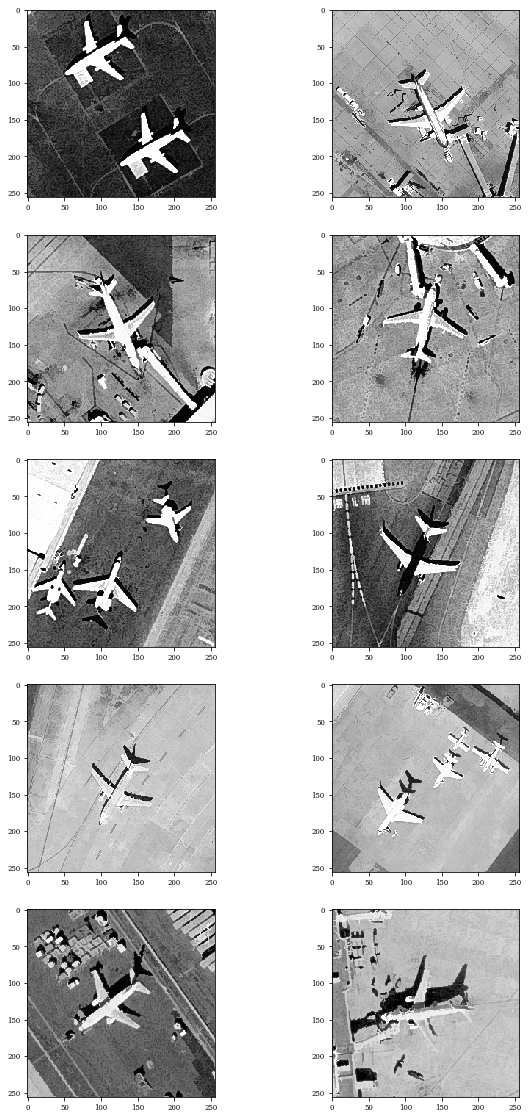

In [100]:
plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()

In [101]:
from morpholayers.layers import ToggleMapping2D
InLayer=Input(size_im)
x=ToggleMapping2D(num_filters=1,kernel_size=(3,3),steps=5)(InLayer)
model=Model(InLayer,x)
model.summary()

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 256, 256, 1)]     0         
_________________________________________________________________
toggle_mapping2d (ToggleMapp (None, 256, 256, 1)       9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [103]:
Z=model.predict(Batch)

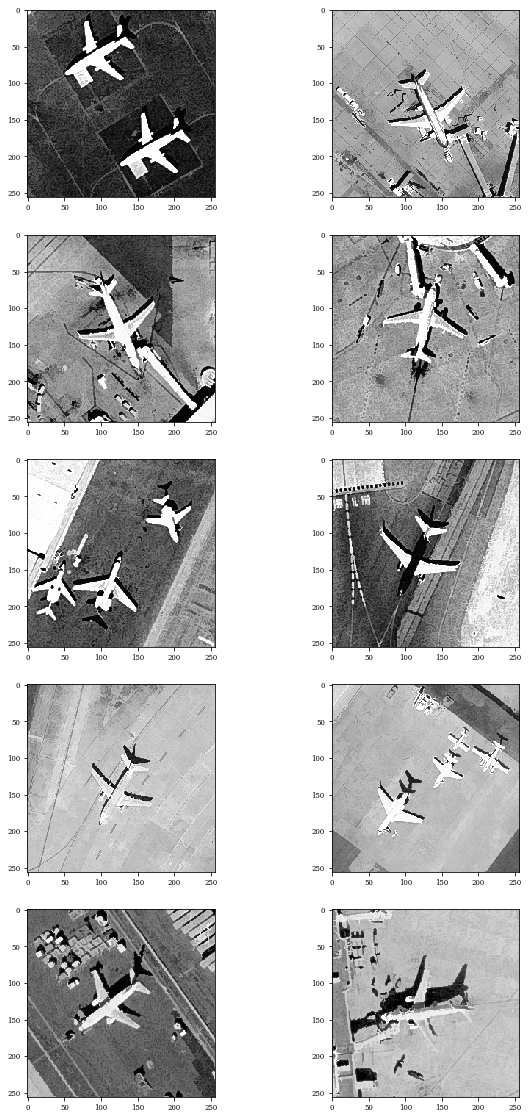

In [104]:
plt.figure(figsize=(15,30))
for i in range(Batch.shape[0]):
    plt.subplot(5,2,i+1)
    plt.imshow(Z[i,:,:,0])
plt.show()





### Exercises

#### Exercises 1:
For all nonflat structuring element $\mathbf{W}$ and any images $\mathbf{X},\mathbf{Y}$.
1. $\dilation_{\SE}(\mathbf{X}+a)= \dilation_{\SE}(\mathbf{X})+a$ and $\erosion_{\SE}(\mathbf{X}+a)= \erosion_{\SE}(\mathbf{X})+a$ 
2. $\dilation_{\SE_1  \vee \SE_2 }  = \dilation_{\SE_1} \vee \dilation_{\SE_2}$
3. $\erosion_{\SE_1  \wedge \SE_2 }  = \erosion_{\SE_1} \wedge \erosion_{\SE_2}$
4. $-\dilation_{\SE}(-\mathbf{X})$ is an erosion, i.e., the negative of a dilation is an erosion.
5. $\dilation_{\SE}$ and $\erosion_{\SE}$ are both translation invariant.
6. Given $a>0$,$\dilation_{\SE}(a \mathbf{X}) = a \delta_{\mathbf{W}}(\mathbf{X})$, if only if $\SE=\mathbf{0}$
7. Given  $a>0$,$\erosion_{\SE}(a \mathbf{X}) = a \erosion_{\SE}(\mathbf{X})$, if only if $\SE=\mathbf{0}$


#### Exercises 2:
1. What are the conditions for $\mathbf{W}$ to have an increasing dilation?
2. What are the conditions for $\mathbf{W}$ to have an increasing erosion?
2. What are the conditions for $\mathbf{W}$ to have extensive dilation?
3. What are the conditions for $\mathbf{W}$ to have anti-extensive erosion?
4. Proof that the pair $(\varepsilon_{\mathbf{W}},\delta_{\mathbf{W}})$ satisfy the adjunction relation $\forall  \mathbf{W}$.

As the Closing operator, works on dark values, we show the results in other images.
